# Subprocess

## 11/9/2023

<a href="?print-pdf">print view</a>

<a href="subprocess.ipynb">notebook</a>

In [1]:
%%html
<script src="https://bits.csb.pitt.edu/preamble.js"></script>

# Going Outside the (Python) Box

Sometimes you need to integrate with programs that don't have a python interface (or you think it would just be easier to use the command line interface).

Python has a versatile subprocess module for calling and interacting with other programs.

However, first the venerable system command:

In [2]:
import os
os.system("curl  http://mscbio2025.csb.pitt.edu -o class.html")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   152  100   152    0     0  11799      0 --:--:-- --:--:-- --:--:-- 12666


0

The return value of the system command is the exit code (not what is printed to screen).

In [3]:
f = open('class.html')
len(f.read())

152

In [18]:
%%html
<div id="sub1" style="width: 500px"></div>
<script>

    var divid = '#sub1';
	jQuery(divid).asker({
	    id: divid,
	    question: "What exit code indicates success?",
		answers: ['-1','0','1','empty string'],
        server: "https://bits.csb.pitt.edu/asker.js/example/asker.cgi",
		charter: chartmaker})
    
$(".jp-InputArea .o:contains(html)").closest('.jp-InputArea').hide();


</script>

# subprocess

The `subprocess` module replaces the following modules (so don't use them):

In [ ]:
os.system
os.spawn*
os.popen*
popen2.*
commands.*

# subprocess.call

In [5]:
ARGS='ls'

In [6]:
!mkdir /tmp/empty

In [7]:
cd /tmp/empty

/tmp/empty


In [8]:
import subprocess
subprocess.call(ARGS, stdin=None, stdout=None, stderr=None, shell=False)

0

Run the command described by `ARGS`. Wait for command to complete, then return the returncode attribute.

<center><img src='../files/call.png' width=350></center>

# ARGS

`ARGS` specifies the command to call and its arguments.  It can either be a **string** or a **list of strings**.

In [9]:
subprocess.call('echo')

0

In [10]:
subprocess.call(['echo','hello'])

hello


0

If `shell=False` (default) and `args` is a string, it must be only the name of the program (no arguments).  If a list is provided, then the first element is the program name and the remaining elements are the arguments.

# shell

If (and only if) `shell = True` then the string provided for `args` is parsed *exactly* as if you typed it on the commandline.  This means you that:

* you must escape special characters (e.g. spaces in file names)
* you can use the wildcard '*' character to expand file names
* you can add IO redirection

If `shell=False` then list arguments must be use and they are passed literally to the program (e.g., it would get '*' for a file name).

`shell` is `False` by default for security reasons.  Consider:

    filename = input("What file would you like to display?\n")
    What file would you like to display?
    non_existent; rm -rf / #
    subprocess.call("cat " + filename, shell=True) # Uh-oh. This will end badly...

Be default `/bin/sh` is used as the shell.  You are probably using `bash`.  You can specify what shell to use with the `executable` argument.

In [11]:
subprocess.call('echo $0',shell=True) #prints out /bin/sh
subprocess.call('echo $0',executable='/bin/bash',shell=True) #prints out /bin/bash

/bin/sh
/bin/bash


0

# shell Examples

In [12]:
subprocess.call(['ls','*']) # ls: *: No such file or directory

ls: cannot access '*': No such file or directory


2

In [13]:
!touch file\ with\ spaces

In [14]:
#note - ls returns nonzero exit code if can't list any files
print(subprocess.call('ls *',shell=True)) #shows all files
print(subprocess.call('ls file with spaces',shell=True)) #tries to ls three different files
print(subprocess.call('ls file\ with\ spaces',shell=True)) #shows single file with spaces in name
print(subprocess.call(['ls','file with spaces'])) #ditto
print(subprocess.call(['ls','file\ with\ spaces'])) #fails since it looks for file with backslashes in name

file with spaces
0
2
file with spaces
0
file with spaces
0
2


ls: cannot access 'file': No such file or directory
ls: cannot access 'with': No such file or directory
ls: cannot access 'spaces': No such file or directory
ls: cannot access 'file\ with\ spaces': No such file or directory


In [15]:
subprocess.call('ls *') #why is this FileNotFoundError?

FileNotFoundError: [Errno 2] No such file or directory: 'ls *'

# Input/Output/Error

Every process (program) has standard places to write output and read input. 

* stdin - standard input is usually from the keyboard
* stdout - standard output is usually buffered
* stderr - standard error is unbuffered (output immediately)

On the commandline, you can changes these places with IO redirection (<,>,|).  For example:
<pre>
    grep Congress cnn.html > congress
    wc < congress
    grep Congress cnn.html | wc
</pre>    
When calling external programs from scripts we'll usually want to provide input to the programs and read their output, so we'll have to change these 'places' as well.

In [17]:
%%html
<div id="stdoutq" style="width: 500px"></div>
<script>

    var divid = '#stdoutq';
	jQuery(divid).asker({
	    id: divid,
	    question: "When you print something in python, where does it go?",
		answers: ['stdin','stdout','stderr','the screen'],
        server: "https://bits.csb.pitt.edu/asker.js/example/asker.cgi",
		charter: chartmaker})
    
$(".jp-InputArea .o:contains(html)").closest('.jp-InputArea').hide();


</script>

# stdin/stdout/stderr

stdin, stdout and stderr specify the executed program’s standard input, standard output and standard error file handles, respectively. Valid values are

* `subprocess.PIPE` - this enables communication between your script and the program
* an existing file object - e.g. created with `open`
* None - the program will default to the existing stdin/stdout/stderr 

**Do no use `subprocess.PIPE` with subprocess.call**

# Redirecting to files

In [20]:
f = open('dump','w')
subprocess.call('ls',stdout=f)
f = open('dump','r') #this would be a very inefficient way to get the stdout of a program
f.readline()

'dump\n'

In [21]:
f = open('dump','w')
subprocess.call(['ls','nonexistantfile'],stdout=f,stderr=subprocess.STDOUT) #you can redirect stderr to stdout

2

In [22]:
print(open('dump').read())

ls: cannot access 'nonexistantfile': No such file or directory



# subprocess.check_call

`check_call` is identical to `call`, but throws an exception when the called program has a nonzero return value.

In [23]:
subprocess.check_call(['ls','missingfile'])

ls: cannot access 'missingfile': No such file or directory


CalledProcessError: Command '['ls', 'missingfile']' returned non-zero exit status 2.

# subprocess.check_output

<center><img src='../files/checkoutput.png'></center>

# subprocess.check_output

In [24]:
subprocess.check_output(ARGS, stdin=None, stderr=None, shell=False)

b'dump\nfile with spaces\n'

Typically, you are calling a program because you want to parse its output.  `check_output` provides the easiest way to do this.  Its return value is what was written to `stdout`.  

Nonzero return values result in a `CalledProcessError` exception (like `check_call`).

In [25]:
files = subprocess.check_output('ls file*',shell=True)
print(files)

b'file with spaces\n'


# subprocess.check_output

Can redirect `stderr` to `STDOUT`

In [26]:
subprocess.check_output("ls non_existent_file; exit 0", stderr=subprocess.STDOUT, shell=True)

b"ls: cannot access 'non_existent_file': No such file or directory\n"

Why `exit 0`?

In [27]:
%%html
<div id="subck" style="width: 500px"></div>
<script>

    var divid = '#subck';
	jQuery(divid).asker({
	    id: divid,
	    question: "Which of the following does NOT produce an error?",
		answers: ['subprocess.check_output(["ls *"],shell=True)','subprocess.check_output("ls","*",shell=True)',
                  'subprocess.check_output(["ls","*"])','subprocess.check_output(["ls *"])'],
        server: "https://bits.csb.pitt.edu/asker.js/example/asker.cgi",
		charter: chartmaker})
    
$(".jp-InputArea .o:contains(html)").closest('.jp-InputArea').hide();


</script>

How can we communicate with the program we are launching?

<center><img src='../files/checkoutput.png'></center>

# Popen

All the previous functions are just convenience wrappers around the Popen object.

In [28]:
subprocess.Popen(ARGS, stdin=None, stdout=None, stderr=None, shell=False, cwd=None, env=None)

<Popen: returncode: None args: 'ls'>

dump
file with spaces


Popen has quite a few optional arguments. Shown are just the most common. 

`cwd` sets the working directory for the process (if `None` defaults to the current working directory of the python script).

`env` is a dictionary that can be used to define a new set of environment variables.

*`Popen` is a constructor and returns a `Popen` object.*  

In [29]:
proc = subprocess.Popen('echo')
type(proc)

subprocess.Popen

# Popen

The python script does **not** wait for the called process to finish before returning.

We can finally use `PIPE`.

<center><img src='../files/pipe.png'></center>

# subprocess.PIPE

If we set stdin/stdout/stderr to `subprocess.PIPE` then they are available to read/write to in the resulting Popen object.

In [30]:
proc = subprocess.Popen('ls',stdout=subprocess.PIPE)

In [31]:
type(proc.stdout)

_io.BufferedReader

In [32]:
print(proc.stdout.readline())

b'dump\n'


# subprocess.PIPE

Pipes enable communication between your script and the called program.  

If `stdout/stdin/stderr` is set to `subprocess.PIPE` then that input/output stream of the process is accessible through a file object in the returned object.

In [33]:
proc = subprocess.Popen('cat',stdin=subprocess.PIPE,stdout=subprocess.PIPE)
proc.stdin.write(b"Hello")
proc.stdin.close()
print(proc.stdout.read())

b'Hello'


python3 strings are unicode, but most programs need byte strings

In [34]:
proc = subprocess.Popen('cat',stdin=subprocess.PIPE,stdout=subprocess.PIPE)
proc.stdin.write("Hello")
proc.stdin.close()
print(proc.stdout.read())

TypeError: a bytes-like object is required, not 'str'

# Unicode (aside)

Bytes strings (which were the default kinds of string in python2) store each character using a single byte (ASCII, like in the Martian).

Unicode uses 1 to 6 bytes per a character.

This allows supports for other languages and the all important emoji.

In [48]:
print('\U0001F984')

🦄


Converting bytes to string

In [36]:
b'a byte str'.decode()

'a byte str'

In [37]:
'a unicode string'.encode()

b'a unicode string'

In [40]:
proc = subprocess.Popen('cat',stdin=subprocess.PIPE,stdout=subprocess.PIPE)
proc.stdin.write(b"Hello")
proc.stdin.close()
print(proc.stdout.read())

b'Hello'


In [38]:
%%html
<div id="sublock" style="width: 500px"></div>
<script>

    var divid = '#sublock';
	jQuery(divid).asker({
	    id: divid,
	    question: "What would happen if in the previous code we omitted the close?",
		answers: ['A','B','C','D'],
        extra: ['Nothing would change','It would not print anything','It would print Hello after a pause','It would hang'],
        server: "https://bits.csb.pitt.edu/asker.js/example/asker.cgi",
		charter: chartmaker})
    
$(".jp-InputArea .o:contains(html)").closest('.jp-InputArea').hide();


</script>

# Warning!

*Managing simultaneous input and output is tricky and can easily lead to deadlocks*.  

For example, your script may be blocked waiting for output from the process which is blocked waiting for input.

<img src="http://i.stack.imgur.com/ezUGt.jpg">



# `Popen.communicate(input=None)`

Interact with process: Send data to stdin. Read data from stdout and stderr, until end-of-file is reached. Wait for process to terminate.

`input` is a string of data to be provided to stdin (which must be set to `PIPE`).  

Likewise, to receive stdout/stderr, they must be set to `PIPE`.

This *will not deadlock*. 

99% of the time if you have to both provide input and read output of a subprocess, communicate will do what you need.


In [41]:
proc = subprocess.Popen("awk '{print $1}'",stdin=subprocess.PIPE,stdout=subprocess.PIPE,stderr=subprocess.PIPE,shell=True)
(out, err) = proc.communicate(b"x y z\n1 2 3\na b c\n") #returns tuple of output and error

In [42]:
print(out.decode())  # decode converts a bytes string to a regular unicode string

x
1
a



# Interacting with Popen

* `Popen.poll()` - check to see if process has terminated
* `Popen.wait()` - wait for process to terminate **Do not use PIPE**
* `Popen.terminate()` - terminate the process (ask nicely)
* `Popen.kill()` - kill the process with extreme prejudice

Note that if your are generating a large amount of data, `communicate`, which buffers all the data in memory, may not be an option (instead just read from `Popen.stdout`).  

If you need to `PIPE` both `stdin` and `stdout` and can't use `communicate`, be *very* careful about controlling how data is communicated.

# Review

* Just want to run a command?
  * `subprocess.call`
* Want the output of the command?
  * `subprocess.check_output`
* Don't want to wait for command to finish?  
  * `subprocess.Popen`
* Need to provide data through stdin?
  * `subprocess.Popen`, `stdin=subprocess.PIPE`, `communicate`

# Exercise

We want to predict the binding affinity of a small molecule to a protein using the program `gnina`. 

For simplicity, run your code starting from this colab:
https://colab.research.google.com/drive/1QYo5QLUE80N_G28PlpYs6OKGddhhd931?usp=sharing

In [43]:
!wget http://mscbio2025.csb.pitt.edu/files/rec.pdb
!wget http://mscbio2025.csb.pitt.edu/files/lig.pdb
!wget http://mscbio2025.csb.pitt.edu/files/receptor.pdb
!wget http://mscbio2025.csb.pitt.edu/files/ligs.sdf

--2023-11-08 16:58:28--  http://mscbio2025.csb.pitt.edu/files/rec.pdb
Resolving mscbio2025.csb.pitt.edu (mscbio2025.csb.pitt.edu)... 136.142.4.139
Connecting to mscbio2025.csb.pitt.edu (mscbio2025.csb.pitt.edu)|136.142.4.139|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 489908 (478K) [chemical/x-pdb]
Saving to: ‘rec.pdb’

rec.pdb             100%[===================>] 478.43K  --.-KB/s    in 0.009s  

2023-11-08 16:58:28 (52.6 MB/s) - ‘rec.pdb’ saved [489908/489908]

--2023-11-08 16:58:28--  http://mscbio2025.csb.pitt.edu/files/lig.pdb
Resolving mscbio2025.csb.pitt.edu (mscbio2025.csb.pitt.edu)... 136.142.4.139
Connecting to mscbio2025.csb.pitt.edu (mscbio2025.csb.pitt.edu)|136.142.4.139|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3536 (3.5K) [chemical/x-pdb]
Saving to: ‘lig.pdb’

lig.pdb             100%[===================>]   3.45K  --.-KB/s    in 0s      

2023-11-08 16:58:28 (519 MB/s) - ‘lig.pdb’ saved [3536/3536]

--2023-11

# Project

1. Run the command `smina -r rec.pdb -l lig.pdb --minimize` on these files.
Parse the affinity and RMSD and print them on one line.
2. Run the command `smina -r receptor.pdb -l ligs.sdf --minimize`.  Parse the affinities and RMSDS.
  1. Plot histograms of both
  2. Plot a scatter plot 

In [44]:
import subprocess, re
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

out = subprocess.check_output('gnina -r receptor.pdb -l ligs.sdf --minimize',shell=True).decode("utf-8") 
affinities = np.array(re.findall(r'Affinity: (\S+)',out),dtype=float)
rmsds = np.array(re.findall(r'RMSD: (\S+)',out),dtype=float)

/home/dkoes/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders



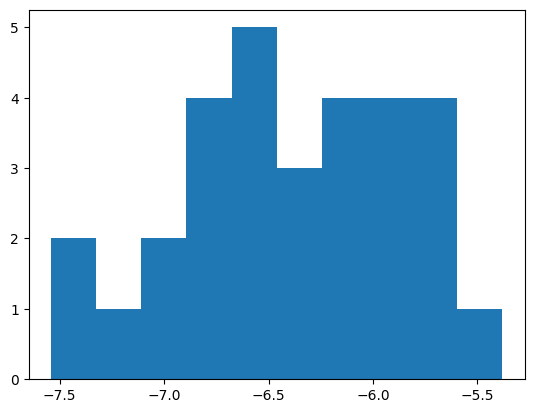

In [45]:
plt.hist(affinities);

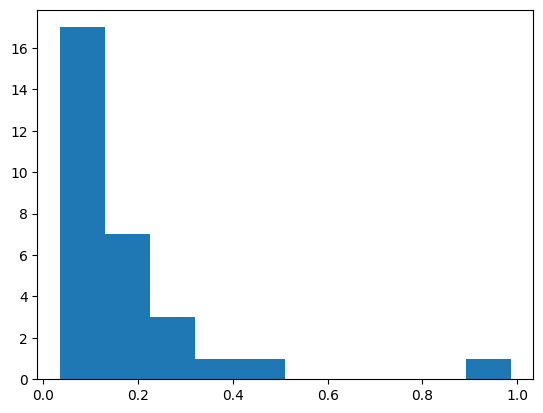

In [46]:
plt.hist(rmsds);

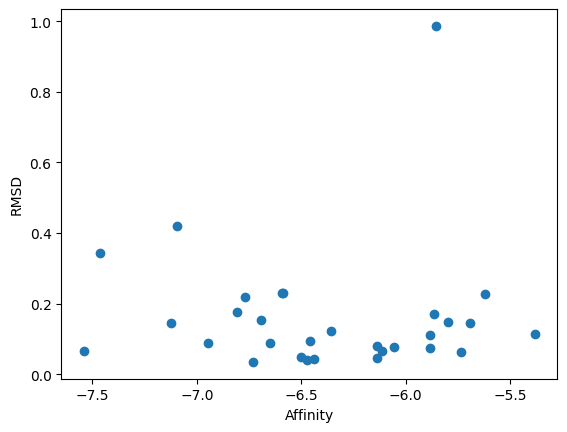

In [47]:
plt.plot(affinities,rmsds,'o')
plt.xlabel("Affinity")
plt.ylabel("RMSD");